# Setup

Import the libraries and methods needed for the project.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.random import set_seed
import tensorflow_datasets as tfds
from tensorflow.keras import (
    Sequential,
    Input, 
    Model
)
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout
)
from tensorflow.keras.layers.experimental.preprocessing import (
    RandomFlip,
    RandomRotation,
    RandomZoom
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

Set the global random number seed to ensure reproducibility.

In [2]:
set_seed(555)

# Helper function

Define a helper function to plot the training and validation metrics.

In [3]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])

# Load the data

Load the STL-10 data from the TensorFlow Datasets collection.

In [4]:
(train, test), info = tfds.load(name = "stl10",
                                split = ["train", "test"],
                                shuffle_files = True,
                                as_supervised = True,
                                with_info = True)

# Build the training pipeline

Fix the autotune, buffer size and batch size parameters.

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = info.splits["train"].num_examples
BATCH_SIZE = 128

Define a function to convert images from the tf.uint8 data type to the tf.float32 data type and normalize them.

In [6]:
def NormalizeImage(image, label):
    return tf.cast(x = image,
                   dtype = tf.float32), label

Compose the training pipeline by applying a sequence of transformations:

- Caching before shuffling for better performance
- Shuffling by setting the shuffle buffer size to be equal to the full dataset size, to ensure true randomness
- Batching after shuffling to ensure I get unique batches at each epoch
- Ending the pipeline by prefetching for performance reasons

In [7]:
train = train.map(NormalizeImage,
                  num_parallel_calls = AUTOTUNE)
train = train.cache()
train = train.shuffle(BUFFER_SIZE)
train = train.batch(BATCH_SIZE)
train = train.prefetch(AUTOTUNE)

# Build the testing pipeline

The testing pipeline is almost identical to the training pipeline, except for two differences:

- Shuffling isn't performed
- Caching is done after batching, since batches may be the same between epochs

In [8]:
test = test.map(NormalizeImage,
                num_parallel_calls = AUTOTUNE)
test = test.batch(BATCH_SIZE)
test = test.cache()
test = test.prefetch(AUTOTUNE)

# Define the data augmentation scheme

Lay out the data augmentation strategy that will be used to add diversity to the dataset.

In [9]:
data_augmentation = Sequential([
    RandomFlip(mode = "horizontal"),
    RandomRotation(factor = 0.1),
    RandomZoom(height_factor = [-0.1, 0.1],
               width_factor = [-0.1, 0.1])
])

# Load a pre-trained base

Load the pre-trained base of the VGG16 model trained on ImageNet.

In [10]:
pretrained_base = VGG16(include_top = False,
                        weights = "imagenet",
                        input_shape = [96, 96, 3])

Unfreeze the pre-trained base so that the learning from the ImageNet dataset is destroyed and must be relearnt from scratch on the new STL-10 dataset.

In [11]:
pretrained_base.trainable = True

# Define the model

Define the inputs and outputs.

In [12]:
inputs = Input(shape = [96, 96, 3])

x = data_augmentation(inputs)

x = pretrained_base(x,
                    training = True)

x = Flatten()(x)

x = Dense(units = 512,
          activation = "relu")(x)

x = Dropout(rate = 0.2)(x)

outputs = Dense(units = 10,
                activation = "softmax")(x)

Combine the inputs and the outputs to create the model.

In [13]:
model = Model(inputs, outputs)

View a summary of all layers in the model.

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130  

Observe that all the parameters in the convolutional base of VGG16 are unfrozen and need to be trained from scratch.

# Compile the model

Compile the model using an optimizer, a loss function and a metric.

In [15]:
model.compile(optimizer = Adam(),
              loss = SparseCategoricalCrossentropy(from_logits = True),
              metrics = [SparseCategoricalAccuracy()])

# Train the model

Train the model for 20 epochs.

In [16]:
history = model.fit(train,
                    epochs = 20,
                    validation_data = test)

Epoch 1/20
40/40 [==============================] - 20s 311ms/step - loss: 13.5330 - sparse_categorical_accuracy: 0.0971 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/20
40/40 [==============================] - 9s 226ms/step - loss: 2.3030 - sparse_categorical_accuracy: 0.0971 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/20
40/40 [==============================] - 9s 227ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0912 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 4/20
40/40 [==============================] - 9s 225ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0999 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 5/20
40/40 [==============================] - 9s 226ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.1003 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/20
40/40 [==============================] - 9s 227ms/step - loss: 2.3026 - sparse_categori

Plot the training and validation loss and sparse accuracy from the training history.

(0.0, 7.193347239494324)

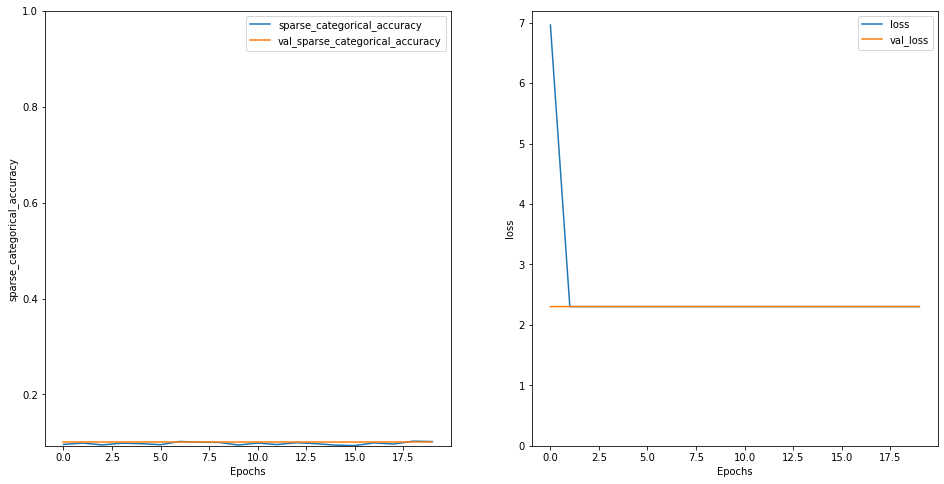

In [17]:
plt.figure(figsize = [16, 8])
plt.subplot(1, 2, 1)
plot_graphs(history, "sparse_categorical_accuracy")
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, "loss")
plt.ylim(0, None)

# Evaluate the model

Perform a final evaluation of the model on the test set.

In [18]:
test_loss, test_accuracy = model.evaluate(test)

print(f"Loss on the test set: {test_loss}")
print(f"Accuracy on the test set: {test_accuracy}")

63/63 [==============================] - 3s 44ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1000
Loss on the test set: 2.302629232406616
Accuracy on the test set: 0.10000000149011612
